# Sandbox for simulating bivariate Guassian random fields

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import model
import sim
import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
param_vals = [0.9, 0.8, 1.5, 1.5, 1.5, 0.2, 0.2, 0.2, 0.0, 0.0, -0.2]
params = model.MaternParams().set_values(param_vals)
mod = model.MultivariateMatern(params=params)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,0.9,"(0.4, 3.5)"
1,sigma_22,0.8,"(0.4, 3.5)"
2,nu_11,1.5,"(0.2, 3.5)"
3,nu_12,1.5,"(0.2, 3.5)"
4,nu_22,1.5,"(0.2, 3.5)"
5,len_scale_11,0.2,"(100.0, 2000.0)"
6,len_scale_12,0.2,"(100.0, 2000.0)"
7,len_scale_22,0.2,"(100.0, 2000.0)"
8,nugget_11,0.0,"(0.0, 0.2)"
9,nugget_22,0.0,"(0.0, 0.2)"


In [17]:
grid = sim.CartesianGrid(xcount=51, ycount=51)
RF = sim.BivariateRandomField(mod, grid, seed=1)
samp = RF.sample(frac=0.6, epsilon=0.2)
samp

,x,y,Z0,Z1
0,0.0,0.00,0.541696,NaN
1,0.0,0.02,0.226823,0.769484
2,0.0,0.06,0.536588,0.502615
3,0.0,0.08,0.442180,0.635375
4,0.0,0.12,0.640381,0.549806
...,...,...,...,...
2336,1.0,0.56,NaN,-1.530416
2337,1.0,0.66,NaN,-0.890153
2338,1.0,0.78,NaN,-1.440546
2339,1.0,0.82,NaN,-1.463526


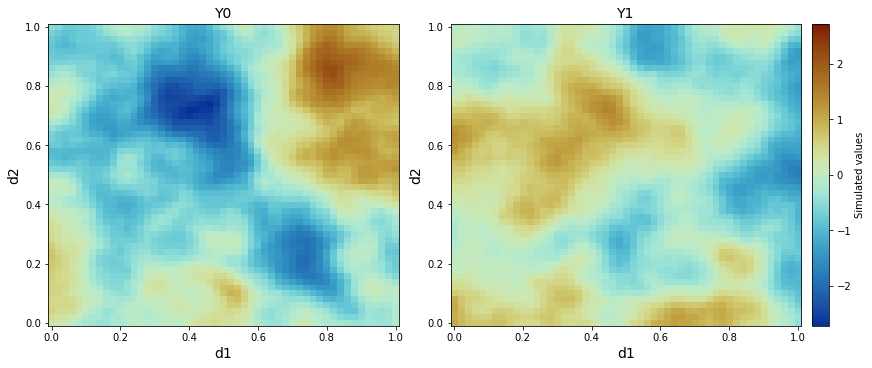

In [44]:
ds = RF.to_xarray()
plot.plot_samples(ds, fontsize=14)

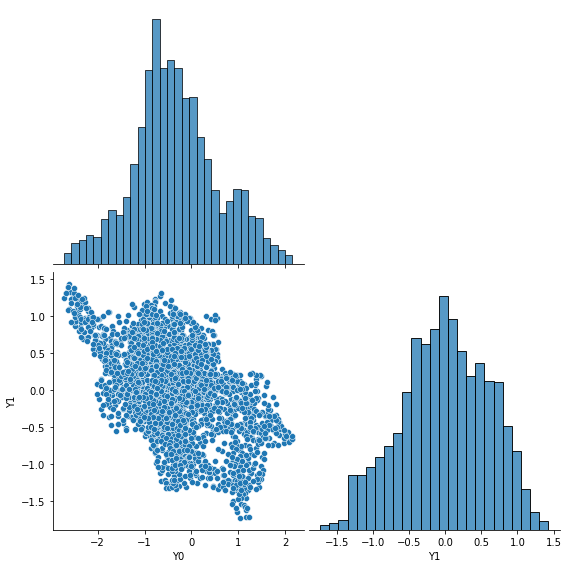

In [47]:
for i, df in enumerate(RF.fields):
    df.rename(columns={"value": f"Y{i}"}, inplace=True)

df = pd.merge(*RF.fields, how="outer")
sns.pairplot(df, vars=["Y0", "Y1"], corner=True, height=4)

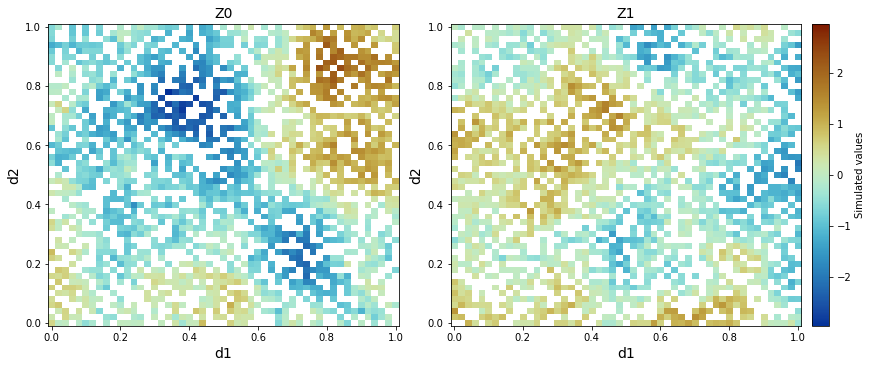

In [45]:
ds = RF.to_xarray(samp)
plot.plot_samples(ds, fontsize=14)

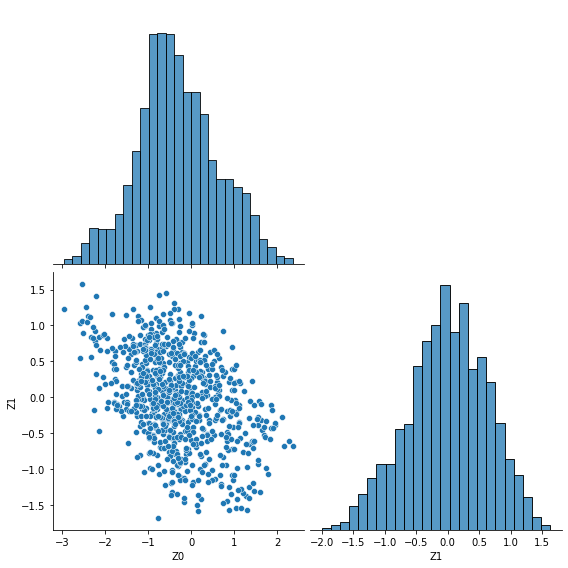

In [19]:
sns.pairplot(samp, vars=["Z0", "Z1"], corner=True, height=4)